# Optimal Placement of Bus Stops using Particle Swarm Optimization

**Citation**: Changyu Li, Ran Ge, Xiangcheng Wu and Alaa Khamis, "Optimal Placement of Bus Stops using Particle Swarm Optimization," IEEE International Conference on Smart Mobility, 2023.

### Introduction

Bus systems play an important role in the modern city. Carefully designed bus stop locations can lift up overall transportation efficiency and save more time for passengers. In this paper, Particle Swarm Optimization (PSO)-based approach is proposed to find the optimal placement of bus stops in Waterloo/Kitchener area. The selection of the bus stops placements takes into account neighborhood population, family income, age distribution, and other factors. The overall goal is to minimize the average travel time of the passengers which is composed of two parts namely passenger time in the bus and out of the bus. Experimental results on real bus lines in  Waterloo/Kitchener region, Canada showed that both PSO and adaptive PSO provide shorter average commuting time compared to the original bus routes. Moreover, the optimized placement needs less number of bus stops compared to the original number of stations.

### Install packages

In [1]:
#!pip install pip install geospatialtools
#!pip install ipyleaflet
#!pip install polyline

In [2]:
import random
import pandas
import math
import copy
from geospatialtools.poi import drawRouteOrder,drawRoute
from geospatialtools.poi import poi
from geopy import distance
import math
import matplotlib.pyplot as plt

### PSO Algorithm

#### Particle class

In [3]:
class Particle:
    def __init__(self, solution, speed, weight, cost=None):
        self.solution = solution
        self.pbest = solution
        self.current_cost = 0
        self.pbest_cost = 0
        self.speed=speed
        self.weight=weight


#### PSO solver

In [4]:
class PSOSolver:
    def __init__(
        self,
        pop_size,
        dis,
        bus_pub,
        inter,
        iterations,
        res,
        original_route
    ):

        self.pop_size = pop_size
        self.population = None
        self.particles = []
        self.dis=dis
        self.bus_pub=bus_pub
        self.iterations = iterations
        self.states = []
        self.intersection=inter
        self.gbest=0
        self.dis_inter=res
        self.original_route=original_route

    def random_solution(self):
        position = [random.randint(0, 1) for x in range(self.intersection.shape[0])]
        position[0]=1
        position[self.intersection.shape[0]-1]=1
        return position

    def random_speed(self):
        speed=[0 for x in range(self.intersection.shape[0])]
        return speed
    
    def random_weight(self):
        weight=[random.random() for x in range(self.intersection.shape[0])]
        #this weight ensure position[0] and position[self.intersection.shape[0]-1] are always 1.
        weight[0]=1
        weight[self.intersection.shape[0]-1]=1
        return weight

    def fitness(self, solution):
      walk_distance_start=[] #distance between each neighbourhood to the boarding stop
      num_stop=[] # number of passing bus stops for the passenger from each neighborhood
      walk_distance_dest=[] #distance between each neighbourhood to the alighting stop
      riding_distance=[]  #riding distance on the bus of each neighborhood
      distance_matrix=self.dis
      for j in range(distance_matrix.shape[0]):
        ls=[]
        # find boarding stop
        blk=distance_matrix.iloc[j:j+1,]
        #print(blk)
        for i in range(len(solution)):
          if solution[i]==0:
            ls.append(i)
        #list all the stops
        blk=blk.drop(blk.columns[ls],axis=1)
        s=blk.min(axis=1)
        #append the distance from the starting point to the boarding stop to the list
        walk_distance_start.append(s.iloc[0])
        #find the index of the intersection (boarding stop)
        for i in range(blk.shape[-1]):
          if blk.iloc[0,i]==s.iloc[0]:
            start=int(blk.columns[i])
            break;
        # start is the location of the boarding stop, dest is the location of the alighting stop, 
        # which are expressed by the index of the intersection
        if (start+20)<len(solution):
          dest=start+20
          num_stop.append(solution[start:start+20].count(1))
        else:
          dest=self.intersection.shape[0]-1
          num_stop.append(solution[start:].count(1))
        # find alighting stop
        distance_intersection=self.dis_inter
        if solution[dest]==1: #destination is exactly the alighting stop
          wlk=0
          riding_dis=distance_intersection[dest]-distance_intersection[start]
        elif solution[dest]==0: #destination is not the alighting stop
          j=dest
          k=dest
          #find the nearest alighting stop to the destination of the passenger
          #the stop may be located behind or ahead of the destination
          while j>0 and solution[j]==0:
            j-=1
          
          while k<len(solution) and solution[k]==0:
            k+=1
          
          wlk=min(distance_intersection[k]-distance_intersection[dest],distance_intersection[dest]-distance_intersection[j])
          if(wlk==distance_intersection[k]-distance_intersection[dest]):
            riding_dis=distance_intersection[k]-distance_intersection[start]
          else:
            riding_dis=distance_intersection[j]-distance_intersection[start]
        #add the walking distance between alighting point and the destination to the list
        walk_distance_dest.append(wlk)
        #add riding distance to the list
        riding_distance.append(riding_dis)

      bus_population=self.bus_pub
      total_walk_distance=0
      total_riding_distance=0
      #walking time and riding time
      for i in range(bus_population.shape[-1]):
        total_walk_distance+=bus_population.iloc[0,i]*walk_distance_start[i]
        total_walk_distance+=bus_population.iloc[0,i]*walk_distance_dest[i]
        total_riding_distance+=riding_distance[i]*bus_population.iloc[0,i]
      t_out=total_walk_distance/1.3 #walk speed
      t_ride=total_riding_distance/4.2 #riding speed,it may change for different route, since each route travel through different geographical areas

      #waiting time
      t_in=0
      for i in range(len(num_stop)):
        t_in+=num_stop[i]*bus_population.iloc[0,i]*30  #30 is the waiting time per stop.It may also change according to different route.
      
      
      
      return (t_out+t_in+t_ride)/60/4573 
      #4573 is the total number of passengers from all the blocks
      #This can be derived from the csv file.
                
        
    
    def initial_population(self):
        #initialze particle
        self.population=[self.random_solution() for _ in range(self.pop_size)]

        speed=[self.random_speed() for _ in range(self.pop_size)]

        weight=[self.random_weight() for _ in range(self.pop_size)]

        for i in range(self.pop_size):
          particle=Particle(solution=self.population[i], speed=speed[i], weight=weight[i])
          particle.pbest=self.population[i]
          particle.pbest_cost=self.fitness(self.population[i])
          particle.current_cost=particle.pbest_cost
          self.particles.append(particle)
    

    def run(self):
      # Check that initial population exists:
      if self.population:         
          print("yes")   
      else:
          raise Exception("Population not initialized.")
      
      for ite in range(self.iterations):
          #find gbest in current iteration
          self.gbest=min(self.particles ,key=lambda x: x.pbest_cost)
          self.states.append(self.gbest.pbest_cost)
          
          if ite%100==0:
            print(self.gbest.pbest_cost)
          
          for particle in self.particles:
            flag=False 
            temp_velocity=[]
            gbest=copy.copy(self.gbest.pbest)
            pbest=particle.pbest
            pbest_cost=particle.pbest_cost
            solution=particle.solution
            speed=particle.speed
            weight=particle.weight
            
            #calculate new speed
            #random Cognitive coeffficient and Social coefficient
            w1=2*random.random()
            w2=2*random.random()
            pdiv=[w1*(pbest[i]-solution[i]) for i in range (len(pbest))]
            gdiv=[w2*(gbest[i]-solution[i]) for i in range (len(gbest))]

            #apply sigmoid function
            speed=[1/(1 + math.exp(-(speed[i]+pdiv[i]+gdiv[i]))) for i in range (len(pbest))]
            
            while flag==False:
              weight=self.random_weight()#generate random weight
              #update new state(bus stop location)
              for i in range(len(pbest)):
                if(speed[i]<weight[i]):
                  solution[i]=1
                else:
                  solution[i]=0
              
              j=0
              k=1
              #check there is 1 bus stop every 8 intersection
              while j<len(solution) and k<len(solution):
                while k<len(solution) and solution[k]==0:
                  k+=1
                if k-j>=8:
                  flag=False
                  break
                else:
                  flag=True
              
                j=k
                k+=1

            if not flag==False:
              #update particle info
              particle.speed=speed
              particle.weight=weight    
              particle.solution=solution
              particle.current_cost=self.fitness(solution)
              if(particle.current_cost<pbest_cost):
                particle.pbest_cost=particle.current_cost
                particle.pbest=solution

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors=[]
        for stop in self.gbest.pbest:
          if stop==1:
            colors.append('blue')  
        poiInfo=self.getpoi()
        return drawRouteOrder(self.getCoordinates(),
            poiInfo,
            range(1,len(poiInfo)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_original(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors=[]
        for stop in self.original_route:
          if stop==1:
            colors.append('blue')  
        poiInfo=self.getpoi_original()
        return drawRouteOrder(self.getCoordinates_ori(),
            poiInfo,
            range(1,len(poiInfo)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def getCoordinates(self):
      ls=[]
      #add longitude and latitude data of the bus stop into the list
      for i in range(len(self.gbest.pbest)):
        if self.gbest.pbest[i]==1:
          loca=(self.intersection.iloc[i,2],self.intersection.iloc[i,3])
          ls.append(loca)
      
      return ls
    
    def getCoordinates_ori(self):
      ls=[]
      #add longitude and latitude data of the bus stop into the list
      for i in range(len(self.original_route)):
        if self.original_route[i]==1:
          loca=(self.intersection.iloc[i,2],self.intersection.iloc[i,3])
          ls.append(loca)
      
      return ls
    
    def getpoi_original(self):
      ls=[]
      # add poi data of the bus stop into the list
      for i in range(len(self.original_route)):
        if self.original_route[i]==1:
          ls.append(poi(self.intersection.iloc[i,1],'canada',self.intersection.iloc[i,2],self.intersection.iloc[i,3]))
      #print(ls)
      return ls
    
    def getpoi(self):
      ls=[]
      # add poi data of the bus stop into the list
      for i in range(len(self.gbest.pbest)):
        if self.gbest.pbest[i]==1:
          ls.append(poi(self.intersection.iloc[i,1],'canada',self.intersection.iloc[i,2],self.intersection.iloc[i,3]))
      return ls
      
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Average time (min)")
        plt.show()

    def oriCost(self):
      print(self.fitness(self.original_route))
      

#### Adaptive PSO solver


In [5]:
class AdaptivePSOSolver:
    def __init__(
        self,
        pop_size,
        dis,
        bus_pub,
        inter,
        iterations,
        res,
        original_route
    ):

        self.pop_size = pop_size
        self.population = None
        self.particles = []
        self.dis=dis
        self.bus_pub=bus_pub
        self.iterations = iterations
        self.states = []
        self.intersection=inter
        self.gbest=0
        self.dis_inter=res
        self.original_route=original_route

    def random_solution(self):
        position = [random.randint(0, 1) for x in range(self.intersection.shape[0])]
        position[0]=1
        position[self.intersection.shape[0]-1]=1
        return position

    def random_speed(self):
        speed=[0 for x in range(self.intersection.shape[0])]
        return speed
    
    def random_weight(self):
        weight=[random.random() for x in range(self.intersection.shape[0])]
        #this weight ensure position[0] and position[self.intersection.shape[0]-1] are always 1.
        weight[0]=1
        weight[self.intersection.shape[0]-1]=1
        return weight

    def fitness(self, solution):
      walk_distance_start=[] #distance between each neighbourhood to the boarding stop
      num_stop=[] # number of passing bus stops for the passenger from each neighborhood
      walk_distance_dest=[] #distance between each neighbourhood to the alighting stop
      riding_distance=[]  #riding distance on the bus of each neighborhood
      distance_matrix=self.dis
      for j in range(distance_matrix.shape[0]):
        ls=[]
        # find boarding stop
        blk=distance_matrix.iloc[j:j+1,]
        #print(blk)
        for i in range(len(solution)):
          if solution[i]==0:
            ls.append(i)
        #list all the stops
        blk=blk.drop(blk.columns[ls],axis=1)
        s=blk.min(axis=1)
        #append the distance from the starting point to the boarding stop to the list
        walk_distance_start.append(s.iloc[0])
        #find the index of the intersection (boarding stop)
        for i in range(blk.shape[-1]):
          if blk.iloc[0,i]==s.iloc[0]:
            start=int(blk.columns[i])
            break;
        # start is the location of the boarding stop, dest is the location of the alighting stop, 
        # which are expressed by the index of the intersection
        if (start+20)<len(solution):
          dest=start+20
          num_stop.append(solution[start:start+20].count(1))
        else:
          dest=self.intersection.shape[0]-1
          num_stop.append(solution[start:].count(1))
        # find alighting stop
        distance_intersection=self.dis_inter
        if solution[dest]==1: #destination is exactly the alighting stop
          wlk=0
          riding_dis=distance_intersection[dest]-distance_intersection[start]
        elif solution[dest]==0: #destination is not the alighting stop
          j=dest
          k=dest
          #find the nearest alighting stop to the destination of the passenger
          #the stop may be located behind or ahead of the destination
          while j>0 and solution[j]==0:
            j-=1
          
          while k<len(solution) and solution[k]==0:
            k+=1
          
          wlk=min(distance_intersection[k]-distance_intersection[dest],distance_intersection[dest]-distance_intersection[j])
          if(wlk==distance_intersection[k]-distance_intersection[dest]):
            riding_dis=distance_intersection[k]-distance_intersection[start]
          else:
            riding_dis=distance_intersection[j]-distance_intersection[start]
        #add the walking distance between alighting point and the destination to the list
        walk_distance_dest.append(wlk)
        #add riding distance to the list
        riding_distance.append(riding_dis)

      bus_population=self.bus_pub
      total_walk_distance=0
      total_riding_distance=0
      #walking time and riding time
      for i in range(bus_population.shape[-1]):
        total_walk_distance+=bus_population.iloc[0,i]*walk_distance_start[i]
        total_walk_distance+=bus_population.iloc[0,i]*walk_distance_dest[i]
        total_riding_distance+=riding_distance[i]*bus_population.iloc[0,i]
      t_out=total_walk_distance/1.3 #walk speed
      t_ride=total_riding_distance/4.2 #riding speed,it may change for different route, since each route travel through different geographical areas

      #waiting time
      t_in=0
      for i in range(len(num_stop)):
        t_in+=num_stop[i]*bus_population.iloc[0,i]*30  #30 is the waiting time per stop.It may also change according to different route.
      
      
      
      return (t_out+t_in+t_ride)/60/4573 
      #4573 is the total number of passengers from all the blocks
      #This can be derived from the csv file.
                
        
    
    def initial_population(self):
        #initialze particle
        self.population=[self.random_solution() for _ in range(self.pop_size)]

        speed=[self.random_speed() for _ in range(self.pop_size)]

        weight=[self.random_weight() for _ in range(self.pop_size)]

        for i in range(self.pop_size):
          particle=Particle(solution=self.population[i], speed=speed[i], weight=weight[i])
          particle.pbest=self.population[i]
          particle.pbest_cost=self.fitness(self.population[i])
          particle.current_cost=particle.pbest_cost
          self.particles.append(particle)
    

    def run(self):
      # Check that initial population exists:
      if self.population:         
          print("yes")   
      else:
          raise Exception("Population not initialized.")
      
      for ite in range(self.iterations):
          #find gbest in current iteration
          self.gbest=min(self.particles ,key=lambda x: x.pbest_cost)
          self.states.append(self.gbest.pbest_cost)
          
          if ite%100==0:
            print(self.gbest.pbest_cost)
          
          for particle in self.particles:
            flag=False 
            temp_velocity=[]
            gbest=copy.copy(self.gbest.pbest)
            pbest=particle.pbest
            pbest_cost=particle.pbest_cost
            solution=particle.solution
            speed=particle.speed
            weight=particle.weight
            
            #calculate new speed
            #Adaptive Cognitive coeffficient and Social coefficient
            w1=(self.iterations-ite)/self.iterations
            w2=2-(self.iterations-ite)/self.iterations
            pdiv=[w1*(pbest[i]-solution[i]) for i in range (len(pbest))]
            gdiv=[w2*(gbest[i]-solution[i]) for i in range (len(gbest))]

            #apply sigmoid function
            speed=[1/(1 + math.exp(-(speed[i]+pdiv[i]+gdiv[i]))) for i in range (len(pbest))]
            
            while flag==False:
              weight=self.random_weight()#generate random weight
              #update new state(bus stop location)
              for i in range(len(pbest)):
                if(speed[i]<weight[i]):
                  solution[i]=1
                else:
                  solution[i]=0
              
              j=0
              k=1
              #check there is 1 bus stop every 8 intersection
              while j<len(solution) and k<len(solution):
                while k<len(solution) and solution[k]==0:
                  k+=1
                if k-j>=8:
                  flag=False
                  break
                else:
                  flag=True
              
                j=k
                k+=1

            if not flag==False:
              #update particle info
              particle.speed=speed
              particle.weight=weight    
              particle.solution=solution
              particle.current_cost=self.fitness(solution)
              if(particle.current_cost<pbest_cost):
                particle.pbest_cost=particle.current_cost
                particle.pbest=solution

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors=[]
        for stop in self.gbest.pbest:
          if stop==1:
            colors.append('blue')  
        poiInfo=self.getpoi()
        return drawRouteOrder(self.getCoordinates(),
            poiInfo,
            range(1,len(poiInfo)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_original(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors=[]
        for stop in self.original_route:
          if stop==1:
            colors.append('blue')  
        poiInfo=self.getpoi_original()
        return drawRouteOrder(self.getCoordinates_ori(),
            poiInfo,
            range(1,len(poiInfo)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def getCoordinates(self):
      ls=[]
      #add longitude and latitude data of the bus stop into the list
      for i in range(len(self.gbest.pbest)):
        if self.gbest.pbest[i]==1:
          loca=(self.intersection.iloc[i,2],self.intersection.iloc[i,3])
          ls.append(loca)
      
      return ls
    
    def getCoordinates_ori(self):
      ls=[]
      #add longitude and latitude data of the bus stop into the list
      for i in range(len(self.original_route)):
        if self.original_route[i]==1:
          loca=(self.intersection.iloc[i,2],self.intersection.iloc[i,3])
          ls.append(loca)
      
      return ls
    
    def getpoi_original(self):
      ls=[]
      # add poi data of the bus stop into the list
      for i in range(len(self.original_route)):
        if self.original_route[i]==1:
          ls.append(poi(self.intersection.iloc[i,1],'canada',self.intersection.iloc[i,2],self.intersection.iloc[i,3]))
      
      return ls
    
    def getpoi(self):
      ls=[]
      # add poi data of the bus stop into the list
      for i in range(len(self.gbest.pbest)):
        if self.gbest.pbest[i]==1:
          ls.append(poi(self.intersection.iloc[i,1],'canada',self.intersection.iloc[i,2],self.intersection.iloc[i,3]))
      
      return ls
      
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Average time (min)")
        plt.show()

    def oriCost(self):
      print(self.fitness(self.original_route))
      

### Solving the problem

In [6]:
# read data
intersection=pandas.read_table("data/Line7(default)/Bus_stops.csv", sep=",") #Coordinates of every intersctions along the route
block_csv = pandas.read_table("data/Line7(default)/Bus_population.csv", sep=",") #number of passengers from each blocks
distance_matrix=pandas.read_table("data/Line7(default)/Distance_matrix.csv", sep=",")#distance between each intersection and the block
bus_population=block_csv.iloc[74:75,:].drop(labels=["Unnamed: 2","Characteristic","topic"],axis=1)# row "Public Transport Population" in the "Bus_population.csv"
#the location of this row may varies in different csv files
pop_size=40
iterations=1000

res=[]
b1_lon=intersection.iloc[0,3]
b1_lat=intersection.iloc[0,2]
b1t=(b1_lat,b1_lon)
for i in range( intersection.shape[0]):
  b2_lon=intersection.iloc[i,3]
  b2_lat=intersection.iloc[i,2]
  b2t=(b2_lat,b2_lon)
  res.append(distance.great_circle(b1t, b2t).m)

In [7]:
#original bus route
No7route=intersection.iloc[:,4].tolist()

In [8]:
solver = PSOSolver(
    pop_size,
    distance_matrix,
    bus_population,
    intersection,
    iterations,
    res,
    No7route
)
solver.initial_population()
solver.oriCost()#original bus route cost

15.929137139578767


In [9]:
adaptiveSolver = AdaptivePSOSolver(
    pop_size,
    distance_matrix,
    bus_population,
    intersection,
    iterations,
    res,
    No7route
)

### Results

#### Original bus route

In [10]:
#original
solver.visualize_original()

#### Run PSO

In [11]:
solver.run()

yes
16.047658174439526
15.078302020719295
15.078302020719295
14.96028026040436
14.96028026040436
14.96028026040436
14.96028026040436
14.96028026040436
14.96028026040436
14.96028026040436


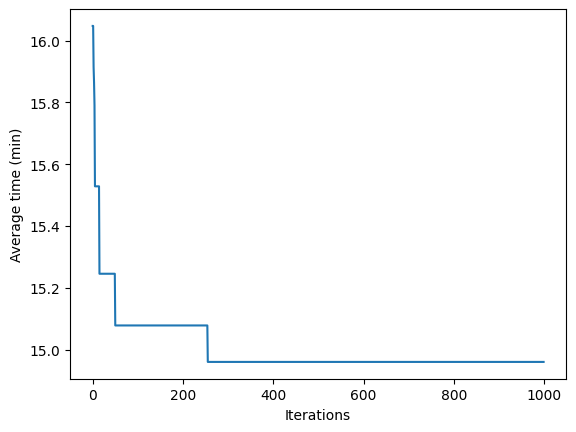

In [12]:
solver.visualize_graph()

In [13]:
solver.visualize_solution()

#### Adaptive PSO

In [14]:
adaptiveSolver.initial_population()
adaptiveSolver.run()

yes
16.02741964007984
14.923033496268186
14.923033496268186
14.923033496268186
14.923033496268186
14.923033496268186
14.923033496268186
14.923033496268186
14.923033496268186


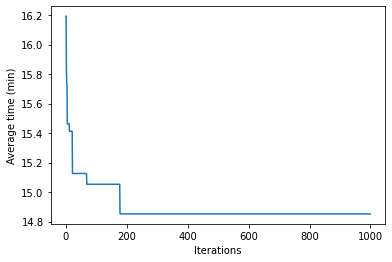

In [ ]:
adaptiveSolver.visualize_graph()

In [ ]:
adaptiveSolver.visualize_solution()

[Name: Conestoga Station ID: 497254259, Name: 455 ID: 4035588161, Name: 7 ID: 4035588683, Name: Wilfrid Laurier University ID: 226405688, Name: 179 ID: 401100764, Name: 18 ID: 401100912, Name: 120 ID: 235654782, Name: 96 ID: 401100329, Name: 39 ID: 401100723, Name: 72 ID: 401100643, Name: 183 ID: 401100403, Name: 11 ID: 4035572988, Name: 780 ID: 401217453, Name: 698 ID: 207900599, Name: 204 ID: 1549292710, Name: 67 ID: 4035503673, Name: Scott Street ID: 2302019139, Name: 289 ID: 401087638, Name: 341 ID: 401087638, Name: 7 ID: 4035503711, Name: King / Pandora ID: 2266363334, Name: 12 ID: 4036642300, Name: Borden Station ID: 5082619953, Name: 568 ID: 4036645063, Name: 10 ID: 4036641763, Name: 4 ID: 4036644235, Name: Eckert / Dixon ID: 1978047425, Name: 151 ID: 4035534335, Name: 391 ID: 4035535383, Name: 15 ID: 4035534315, Name: 11 ID: 4035533592, Name: 2973 ID: 401077152, Name: 159 ID: 401077801]
